**IMPORTS**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb


**LOAD DATA**

In [ ]:
train = pd.read_csv('/content/sample_data/train.csv', low_memory=False)
test = pd.read_csv('/content/sample_data/test.csv')
store = pd.read_csv('/content/sample_data/store.csv')
sample_submission = pd.read_csv('/content/sample_data/sample_submission.csv')


In [ ]:
print(train.info())
print(train.head())
print(train.tail())
print("Shape:", train.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  

In [ ]:
print(test.info())
print(test.head())
print(test.tail())
print("Shape:", test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB
None
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0


In [ ]:
print(store.info())
print(store.head())
print(store.tail())
print("Shape:", store.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                      

In [ ]:
print(sample_submission.info())
print(sample_submission.head())
print(sample_submission.tail())
print("Shape:", sample_submission.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      41088 non-null  int64
 1   Sales   41088 non-null  int64
dtypes: int64(2)
memory usage: 642.1 KB
None
   Id  Sales
0   1      0
1   2      0
2   3      0
3   4      0
4   5      0
          Id  Sales
41083  41084      0
41084  41085      0
41085  41086      0
41086  41087      0
41087  41088      0
Shape: (41088, 2)


**MERGE WITH STORE DATA**

In [ ]:
train = pd.merge(train, store, how='left', on='Store')
test = pd.merge(test, store, how='left', on='Store')

 **Remove Closed/Zero-Sale Entries**

In [ ]:
train = train[train['Sales'] > 0]

**Feature Engineering: Date Parts**

In [ ]:
for df in [train, test]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

In [ ]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,4,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,4,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,4,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,4,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,4,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [ ]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,1,3,2015-09-17,1.0,1,0,0,c,a,...,9.0,2008.0,0,NaN,NaN,NaN,2015,9,17,38
1,2,3,3,2015-09-17,1.0,1,0,0,a,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38
2,3,7,3,2015-09-17,1.0,1,0,0,a,c,...,4.0,2013.0,0,NaN,NaN,NaN,2015,9,17,38
3,4,8,3,2015-09-17,1.0,1,0,0,a,a,...,10.0,2014.0,0,NaN,NaN,NaN,2015,9,17,38
4,5,9,3,2015-09-17,1.0,1,0,0,a,c,...,8.0,2000.0,0,NaN,NaN,NaN,2015,9,17,38


**Handle Missing Values**

In [ ]:
for df in [train, test]:
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())
    df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0)
    df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0)
    df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0)
    df['PromoInterval'] = df['PromoInterval'].fillna('None')


**Encode Categorical Features**

In [ ]:
label_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

**EDA Visualizations**

1. **Univariate Analysis (One Variable at a Time)**

**Numerical Features**

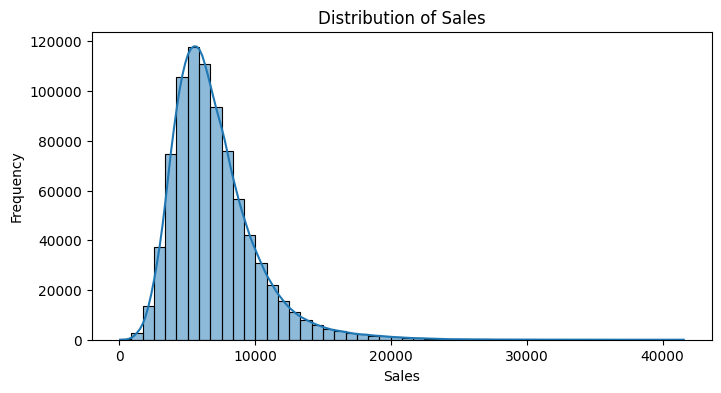

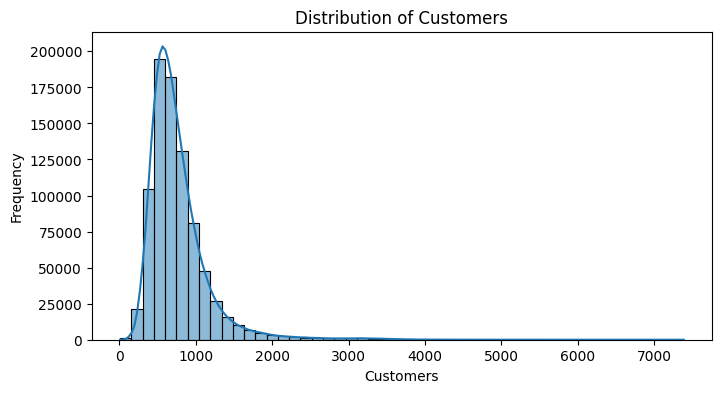

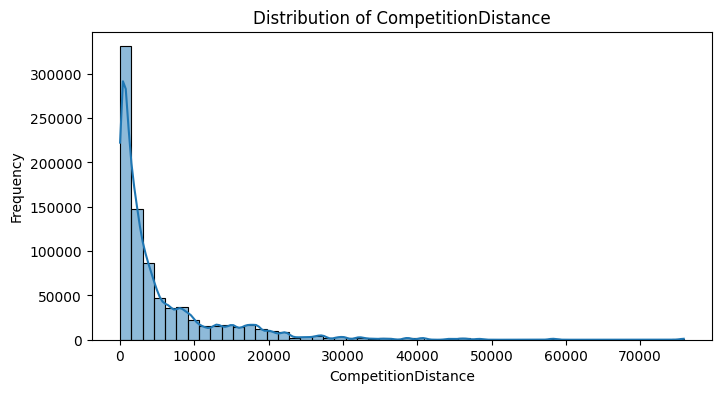

In [ ]:
numeric_cols = ['Sales', 'Customers', 'CompetitionDistance']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


**Categorical Features**

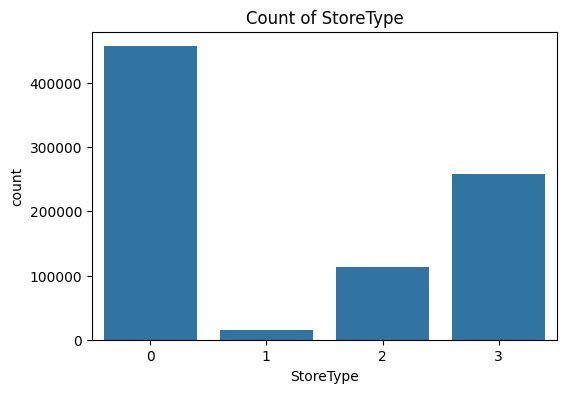

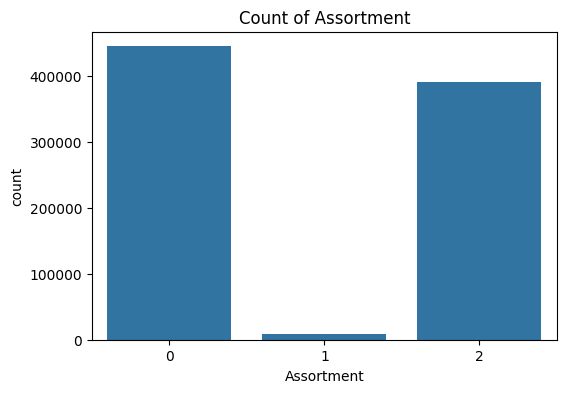

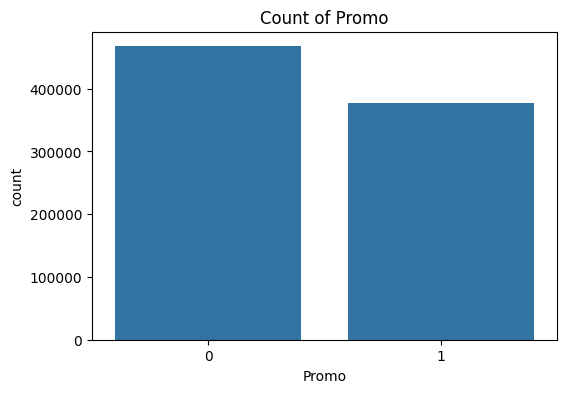

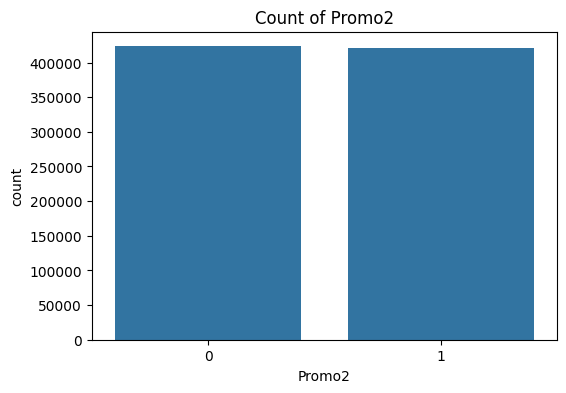

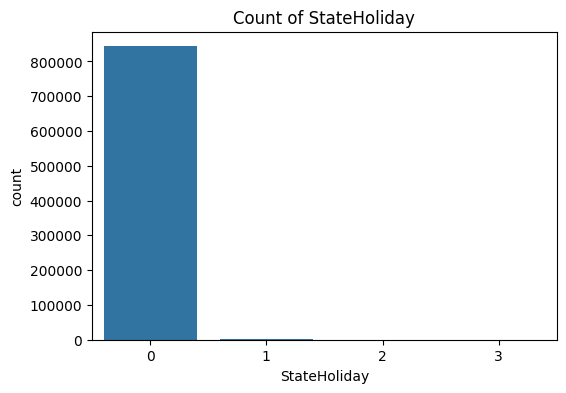

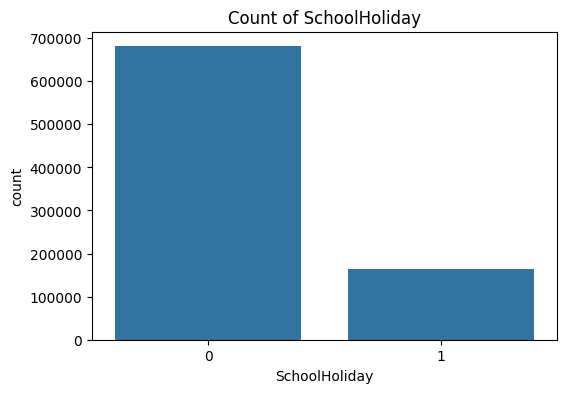

In [ ]:
cat_cols = ['StoreType', 'Assortment', 'Promo', 'Promo2', 'StateHoliday', 'SchoolHoliday']

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=train)
    plt.title(f'Count of {col}')
    plt.show()


2. **Bivariate Analysis (Two Variables)**

**Categorical vs Sales (Boxplots)**

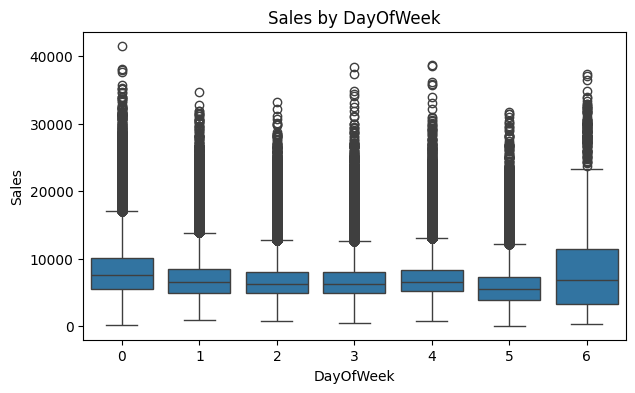

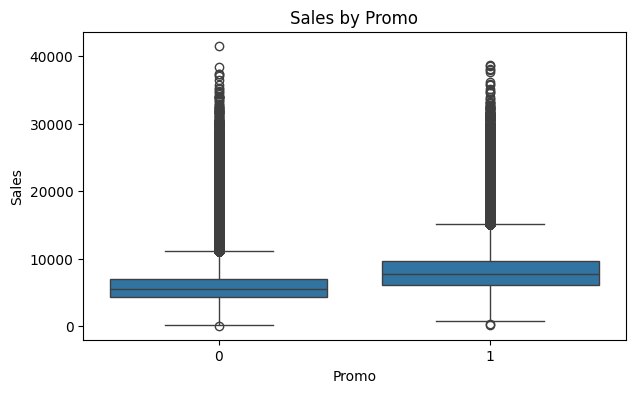

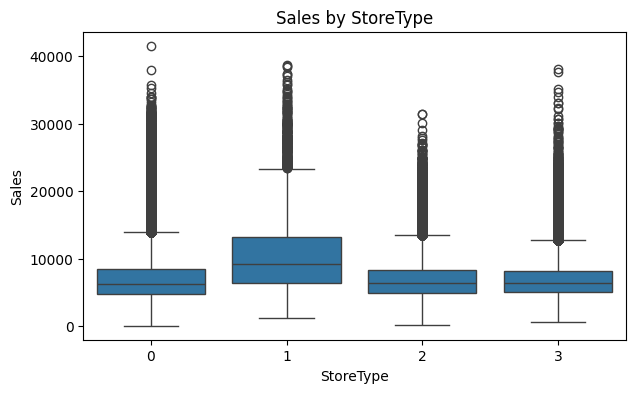

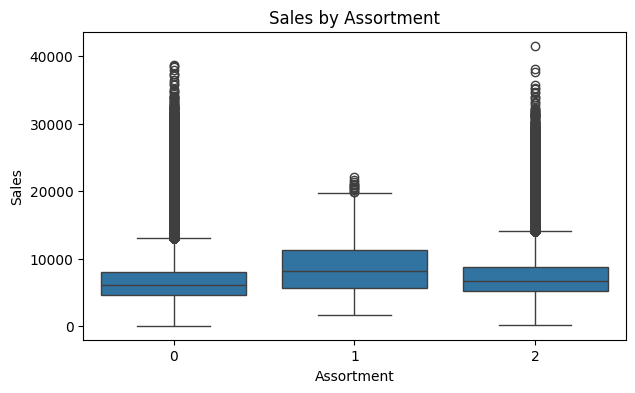

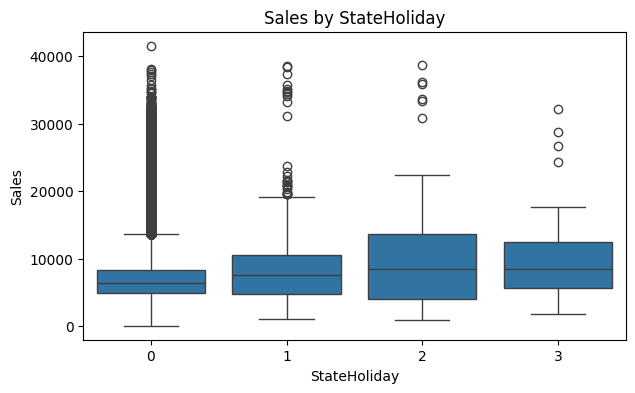

In [ ]:
for col in ['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'StateHoliday']:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=col, y='Sales', data=train)
    plt.title(f'Sales by {col}')
    plt.show()


**Numerical vs Sales (Scatterplots)**

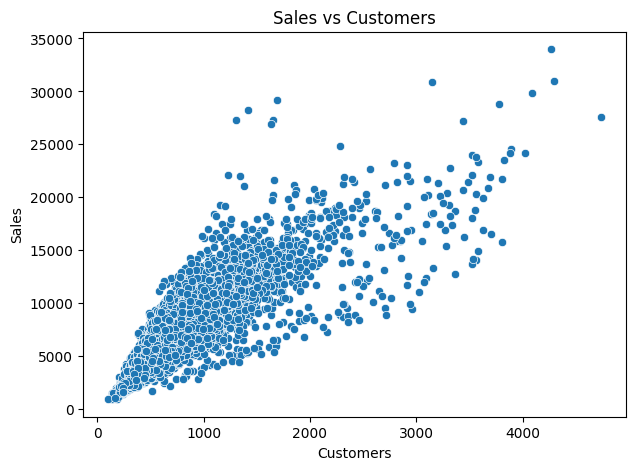

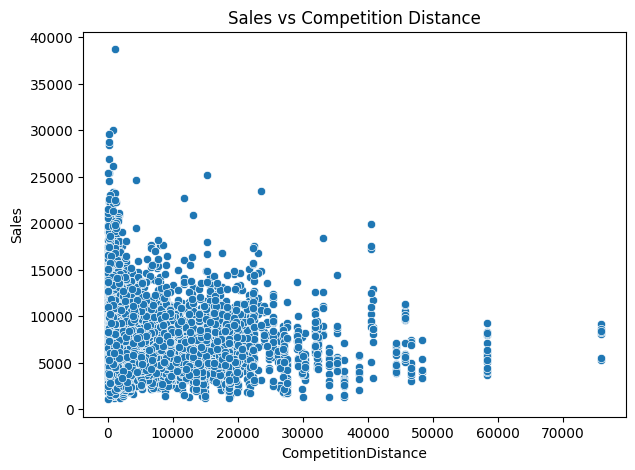

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Customers', y='Sales', data=train.sample(10000))
plt.title('Sales vs Customers')
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=train.sample(10000))
plt.title('Sales vs Competition Distance')
plt.show()


3. **Multivariate Analysis (Multiple Features Together)**

**Correlation Heatmap (Only Numeric Features)**

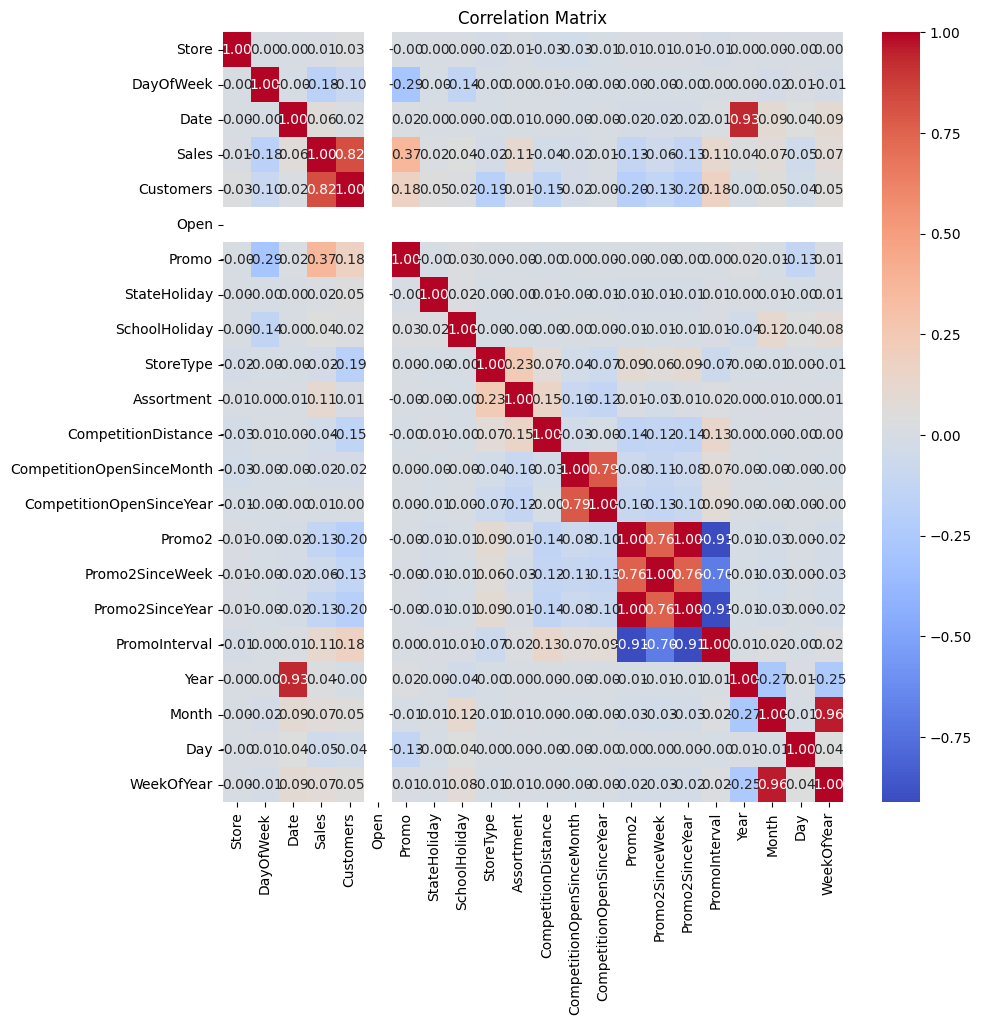

In [ ]:
# Encode categorical features for correlation
corr_df = train.copy()
cat_encode = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
for col in cat_encode:
    corr_df[col] = corr_df[col].astype('category').cat.codes

plt.figure(figsize=(10, 10))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**Pairplot (numerical features)**

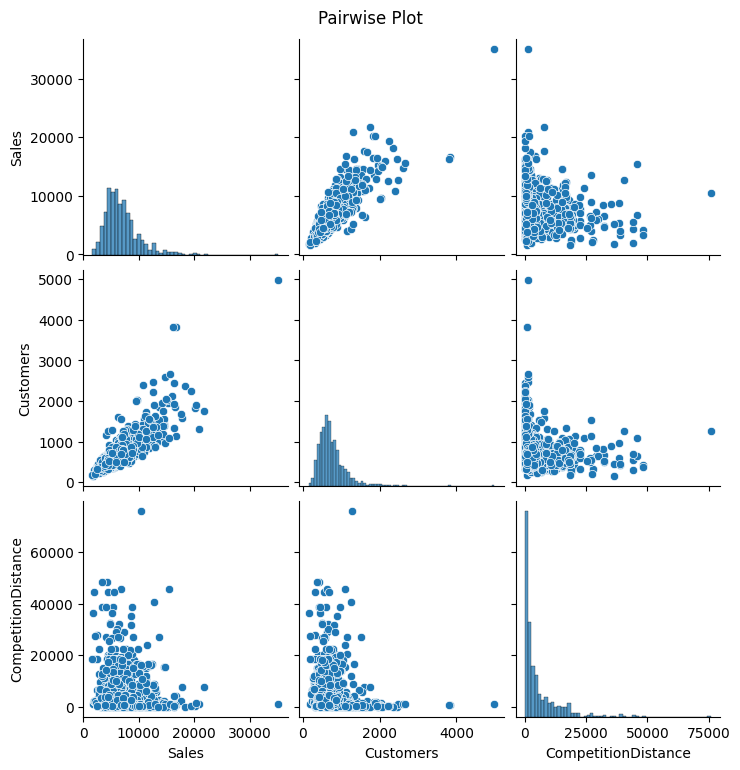

In [ ]:
sns.pairplot(train[['Sales', 'Customers', 'CompetitionDistance']].sample(1000))
plt.suptitle('Pairwise Plot', y=1.02)
plt.show()


**Feature Selection**

In [ ]:
features = [
    'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday',
    'StateHoliday', 'StoreType', 'Assortment', 'PromoInterval',
    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
    'Year', 'Month', 'Day', 'WeekOfYear'
]

**Log transform**

In [ ]:
X = train[features]
y = np.log1p(train['Sales'])

**Train-Test Split**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Train Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

**Training and Evaluation**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize Random Forest with fewer trees for faster training
model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# If target was log1p transformed, apply expm1 to reverse it
y_val_exp = np.expm1(y_val)
y_pred_exp = np.expm1(y_pred)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val_exp, y_pred_exp))
print(" Validation RMSE:", round(rmse, 2))


✅ Validation RMSE: 915.26


**XGBOOST VALIDATION**

**Fold-Wise RMSE**

In [ ]:
!pip install xgboost


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm as lgb
import numpy as np

# Log-transform target
y = np.log1p(train_merged['Sales'])  # log1p compresses large sales
X = train_merged[features]           # features defined earlier

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for i, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMRegressor(
        n_estimators=500,  # No early stopping, so use fewer trees
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    preds = model.predict(X_val)

    # Convert predictions and actuals back to original scale
    rmse = sqrt(mean_squared_error(np.expm1(y_val), np.expm1(preds)))
    rmse_scores.append(rmse)

    print(f"Fold {i} RMSE: {rmse:.2f}")

print(f"\nMean CV RMSE: {np.mean(rmse_scores):.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 675513, number of used features: 17
[LightGBM] [Info] Start training from score 8.757269
Fold 1 RMSE: 1326.19
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 708
[LightGBM] [Info] Number of data points in the train set: 675513, number of used features: 17
[LightGBM] [Info] Start training from score 8.757637
Fold 2 RMSE: 1304.85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

In [ ]:
# Assuming you already predicted final_sales = np.expm1(y_test_pred)
submission = pd.DataFrame({
    'Id': test['Id'],
    'Sales': final_sales
})
submission.to_csv('submission_lgbm.csv', index=False)
print("LightGBM submission saved as 'submission_lgbm.csv'")


LightGBM submission saved as 'submission_lgbm.csv'


In [ ]:
from google.colab import files
files.download('submission_lgbm.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>